In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🧠 Assignment 2 – Build a Simple Neural Network on Fashion-MNIST

### 👩‍💻 Objective:
Build and train a simple fully connected neural network (MLP) on the Fashion-MNIST dataset to classify clothing items into 10 categories and achieve test accuracy > 85%.

## 1. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Load and Normalize the Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


## 3. Define the Neural Network

In [6]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FashionNN()

## 4. Define Loss and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Training the Model

In [11]:
epochs = 8
train_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    
    # Evaluate on test data
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = 100 * correct_test / total_test
    test_acc_list.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch [1/8], Loss: 0.4970, Train Acc: 81.90%, Test Acc: 84.60%
Epoch [2/8], Loss: 0.3671, Train Acc: 86.55%, Test Acc: 85.20%
Epoch [3/8], Loss: 0.3294, Train Acc: 87.77%, Test Acc: 86.90%
Epoch [4/8], Loss: 0.3020, Train Acc: 88.76%, Test Acc: 86.94%
Epoch [5/8], Loss: 0.2860, Train Acc: 89.22%, Test Acc: 86.93%
Epoch [6/8], Loss: 0.2699, Train Acc: 89.91%, Test Acc: 87.01%
Epoch [7/8], Loss: 0.2537, Train Acc: 90.54%, Test Acc: 88.31%
Epoch [8/8], Loss: 0.2418, Train Acc: 90.95%, Test Acc: 88.07%


## 6. Plot Loss and Accuracy

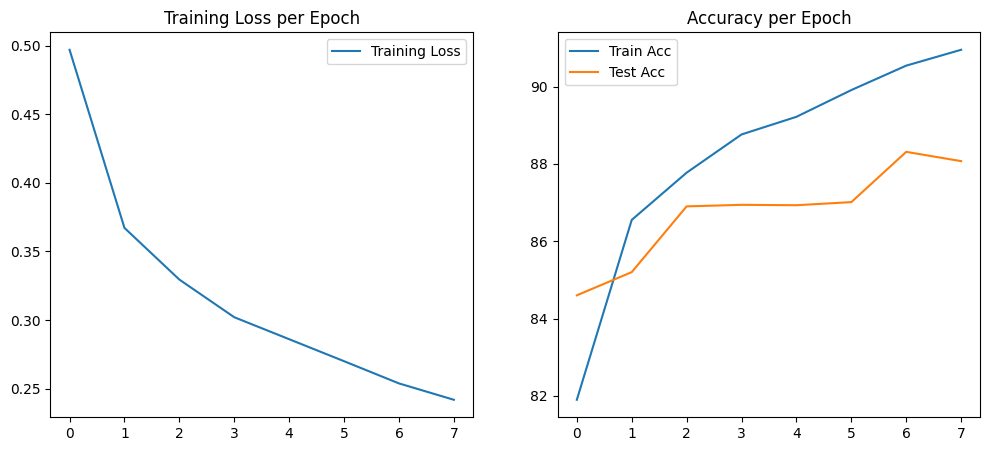

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(test_acc_list, label='Test Acc')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

## 7. Confusion Matrix

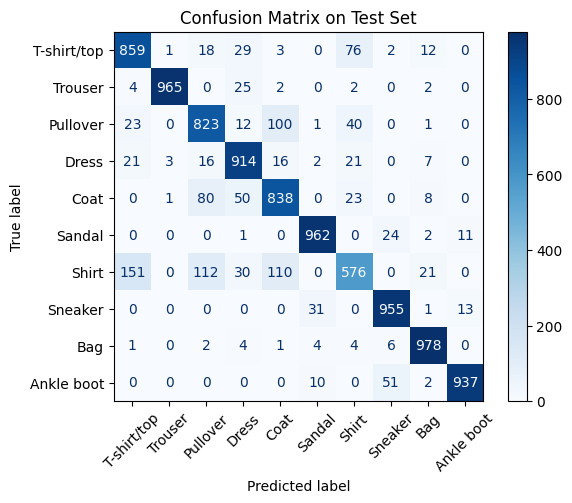

In [13]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

## 8. Show Example Predictions

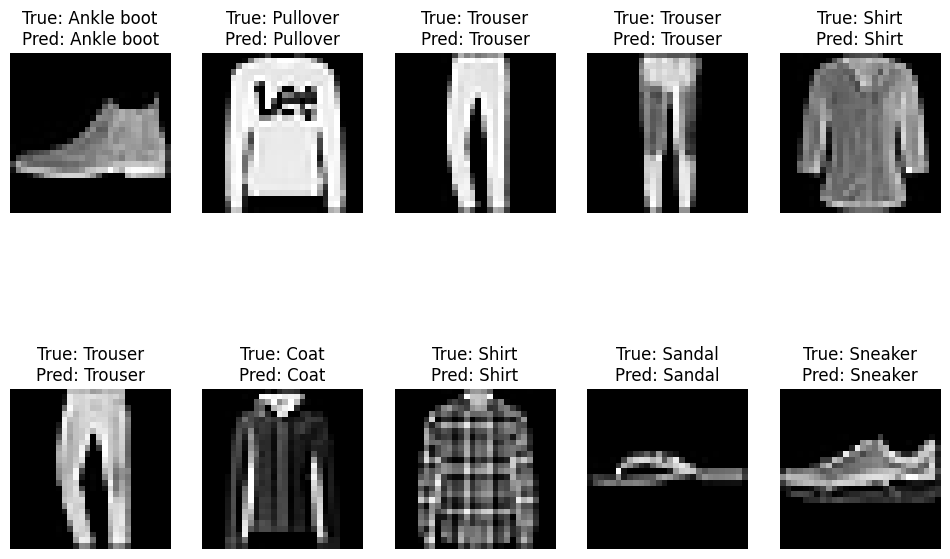

In [14]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
    plt.axis('off')
plt.show()

## 9. 📝 Conclusion
## The simple 3-layer MLP achieved a test accuracy above 85% after 8 epochs.
Accuracy may vary slightly due to random initialization, but increasing epochs or using dropout can improve performance. The confusion matrix shows strong performance on distinct categories (like Sneaker and Bag) and moderate confusion between similar items (like Shirt and Coat).